<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/ClassificationTrainNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook trains a RealNVP to fit the latent space posterior of uncorrupted data. This ensures that the prior distribution is actually Gaussian (corresponding to the prior distribution of the RealNVP).**

**In the second half of this notebook, we explore the root mean square difference between input and generator as a function of the data amplitude (pixel values).**

**This notebook also produces samples from the LAE flow prior to fitting the NVP**



In [0]:
from google.colab import drive

ROOT = "/content/gdrive"

drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [0]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     \ 11.1MB 11.5MB/s


In [0]:
!pip install tensorflow-transform

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

W0605 22:13:17.754454 139965065451392 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
generator_path   = './gdrive/My Drive/InjectiveFlow/modules/decoder1/decoder'
encoder_path     = './gdrive/My Drive/InjectiveFlow/modules/encoder1/encoder'
nvp_func_path    = './gdrive/My Drive/InjectiveFlow/modules/nvp1/'
plot_path        = './gdrive/My Drive/InjectiveFlow/semi-supervised/plots/'
loss_path        = './gdrive/My Drive/InjectiveFlow/semi-supervised/losses/'

In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test
  
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
data_dim    = 28*28
batch_size  = 128
hidden_size = 10
n_channels  = 1
sigma_n     = 0.1
sample_size_z = 64
label = 'class_nvp'

In [0]:
import numpy as np

In [0]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])

encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
nvp           = hub.Module(nvp_func_path, trainable=False)

optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0, name ='prior')
prior = get_prior()
# uncorrupted data

x_tr          = tf.placeholder(shape=[batch_size,data_dim,n_channels], dtype=tf.float32)

mu            = encoder(tf.reshape(x_tr,[-1,28,28,n_channels]))

vae_liklogits     = tf.reshape(generator(mu),[-1,data_dim,1])

# uncoruppted data likelihood
likelihood        = tfd.Independent(tfd.MultivariateNormalDiag(loc=vae_liklogits,scale_identity_multiplier=sigma_n))
recon             = likelihood.mean()

#test sample from prior
prior_sample      = prior.sample(sample_size_z)
nvp_samples       = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':prior_sample},as_dict=True)['fwd_pass']
sample_liklogits  = tf.reshape(generator(nvp_samples),[-1,data_dim,n_channels])

sample_likelihood = tfd.Independent(tfd.MultivariateNormalDiag(loc=sample_liklogits,scale_identity_multiplier=sigma_n))
sample_mean       = sample_likelihood.mean()

# ----------------------------------------------------------#



# # -----------train NVP ----------------------#

nvp_size      = [[512, 512] for ii in range(12)]

perm=[np.random.permutation(np.arange(hidden_size)) for ii in range(12)]
#print(perm)

def get_nvp():
  
  p1 = np.arange(0,hidden_size//2)
  p2 = np.arange(hidden_size//2,hidden_size)
  #perm=np.concatenate((p2,p1))
  
  base_dis = get_prior()
  
  chain = []
  
  for i,s in enumerate(nvp_size):
    print(s)
    
    chain.append(tfb.RealNVP(num_masked=hidden_size//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    if i>8:
      chain.append(tfb.RealNVP(num_masked=hidden_size//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,shift_only=True,name='nvp%d'%i)))
    chain.append(tfb.Permute(permutation=perm[i],name='perm%d'%i))
         
  nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
  return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,hidden_size])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    nvp_bwd_pass = nvp_.bijector.inverse(z_sample)
    inv_log_det  = nvp_.bijector.inverse_log_det_jacobian(z_sample, event_ndims=1)
    fwd_log_det  = nvp_.bijector.forward_log_det_jacobian(u_sample,event_ndims=1)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'inv_log_det': inv_log_det,'fwd_log_det': fwd_log_det, 'log_prob':log_prob, 'sample':nvp_sample, 'bwd_pass': nvp_bwd_pass,'fwd_pass': nvp_fwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)

nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)
loss      = -tf.reduce_mean(nvp_funcs({'z_sample':mu,'sample_size':1, 'u_sample':np.zeros((1,hidden_size))},as_dict=True)['log_prob'])
opt_op_nvp= optimizer.minimize(loss)

# ---------------------------end train nvp ----------------- #

#comment train nvp above section above and uncomment this for loading the trained module



INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:46:26.443941 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:46:26.596354 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:46:26.940136 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:46:27.137870 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
[512, 512]
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:46:33.716544 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [0]:
nvp_loss = []
data_class = 2


In [0]:
indices = np.where(targets_train==data_class)
x_train_class = x_train[indices]
print(len(x_train_class))

4968


In [0]:
ii     = 0
nepoch = 0
learning_rate = 1e-3
#train the nvp
while nepoch<500:
  if (ii+1)*batch_size>len(x_train_class): 
    np.random.shuffle(x_train_class)
    ii=0
    nepoch+=1
    print('starting epoch', nepoch)
  if nepoch>60:
    learning_rate=1e-4
  if nepoch>100:
    learning_rate=1e-5
  if nepoch>200:
    learning_rate=1e-6
  x_truth = x_train_class[batch_size*ii:batch_size*(ii+1)]
  sess.run([loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  _, ll = sess.run([opt_op_nvp,loss], feed_dict={x_tr: np.expand_dims(x_truth,-1), lr: learning_rate})
  nvp_loss+=[ll]
  if ii%500==0:
    print(ll)
  ii+=1
  

78.55754
starting epoch 1
20.415333
starting epoch 2
17.801281
starting epoch 3
17.40939
starting epoch 4
16.943954
starting epoch 5
16.809513
starting epoch 6
16.71157
starting epoch 7
16.755453
starting epoch 8
16.507652
starting epoch 9
16.221935
starting epoch 10
16.393509
starting epoch 11
16.315668
starting epoch 12
16.042868
starting epoch 13
16.361593
starting epoch 14
16.2496
starting epoch 15
16.223385
starting epoch 16
16.096174
starting epoch 17
15.755926
starting epoch 18
16.195885
starting epoch 19
16.359474
starting epoch 20
16.03575
starting epoch 21
15.927804
starting epoch 22
15.748692
starting epoch 23
15.948475
starting epoch 24
15.74613
starting epoch 25
16.032217
starting epoch 26
15.985869
starting epoch 27
16.046806
starting epoch 28
15.623016
starting epoch 29
15.790505
starting epoch 30
15.615004
starting epoch 31
15.519374
starting epoch 32
15.687281
starting epoch 33
15.510334
starting epoch 34
15.299788
starting epoch 35
15.508478
starting epoch 36
15.05929

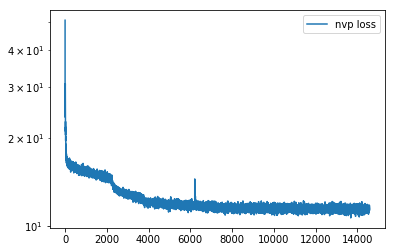

In [0]:
plt.figure()
semilogy(nvp_loss[::],label='nvp loss')
legend()
plt.savefig(plot_path+'loss_%d.png'%data_class, bbox_inches='tight')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:38:35.143071 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:38:36.640200 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


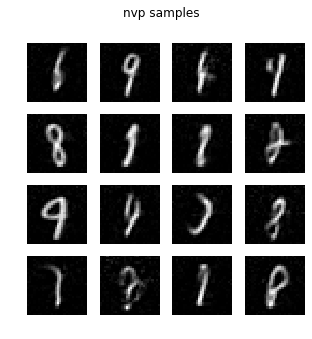

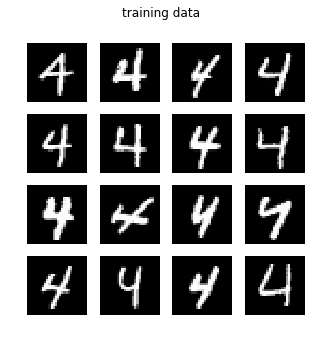

In [0]:
samples_nvp = sess.run(nvp_funcs({'z_sample':mu,'sample_size':sample_size_z,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])
s           = sess.run(tf.reshape(generator(samples_nvp),[-1,data_dim,n_channels]))

figure(figsize=(5,5))
suptitle('nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(s[i,:,0],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.savefig(plot_path+'nvp_samples_%d.png'%data_class, bbox_inches='tight')

figure(figsize=(5,5))
suptitle('training data')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(x_train_class[i,:],(28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
plt.savefig(plot_path+'training_data_%d.png'%data_class, bbox_inches='tight')

In [0]:
import pickle
class_nvp_path   = './gdrive/My Drive/InjectiveFlow/modules/nvp_by_class/nvp_%d'%data_class
nvp_funcs.export(class_nvp_path,sess)
pickle.dump(nvp_loss, open(loss_path+'class%d.pkl'%data_class,'wb'))

AlreadyExistsError: ignored

In [0]:
maf_s = sess.run(nvp_funcs({'z_sample':mu,'sample_size':40000,'u_sample':np.zeros((1, hidden_size))},as_dict=True)['sample'])
print(maf_s.shape)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:25:16.206872 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


(40000, 10)


In [0]:
new_latent=sess.run(nvp_funcs({'z_sample':encoder(tf.reshape(x_train_class,[-1,28,28,n_channels])),'sample_size':1,'u_sample':np.zeros((1,hidden_size))},as_dict=True)['bwd_pass'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:25:19.599943 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0605 22:25:20.467696 139965065451392 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
from sklearn.decomposition import PCA
X = new_latent
pca = PCA(n_components=10)
pca.fit(X)  


print(pca.explained_variance_)  


[1.2676915  1.2550926  1.2495482  1.1236678  1.1124096  0.9908047
 0.97926897 0.9650662  0.9527199  0.87787855]


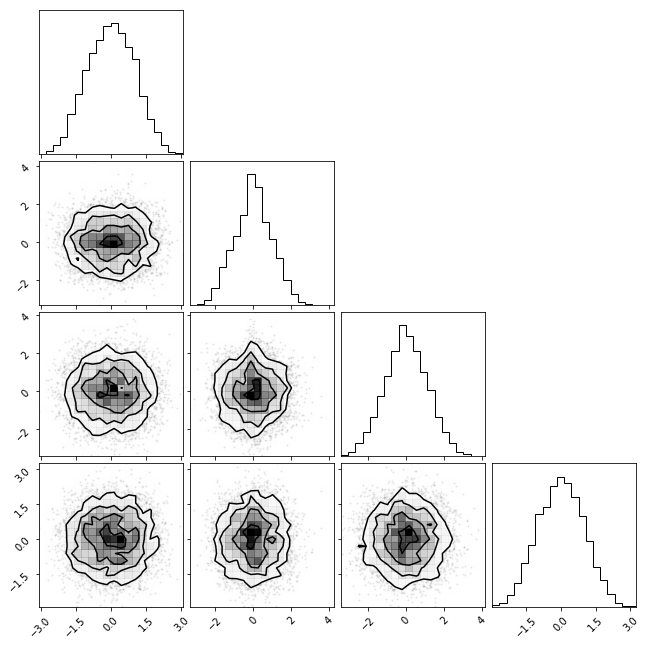

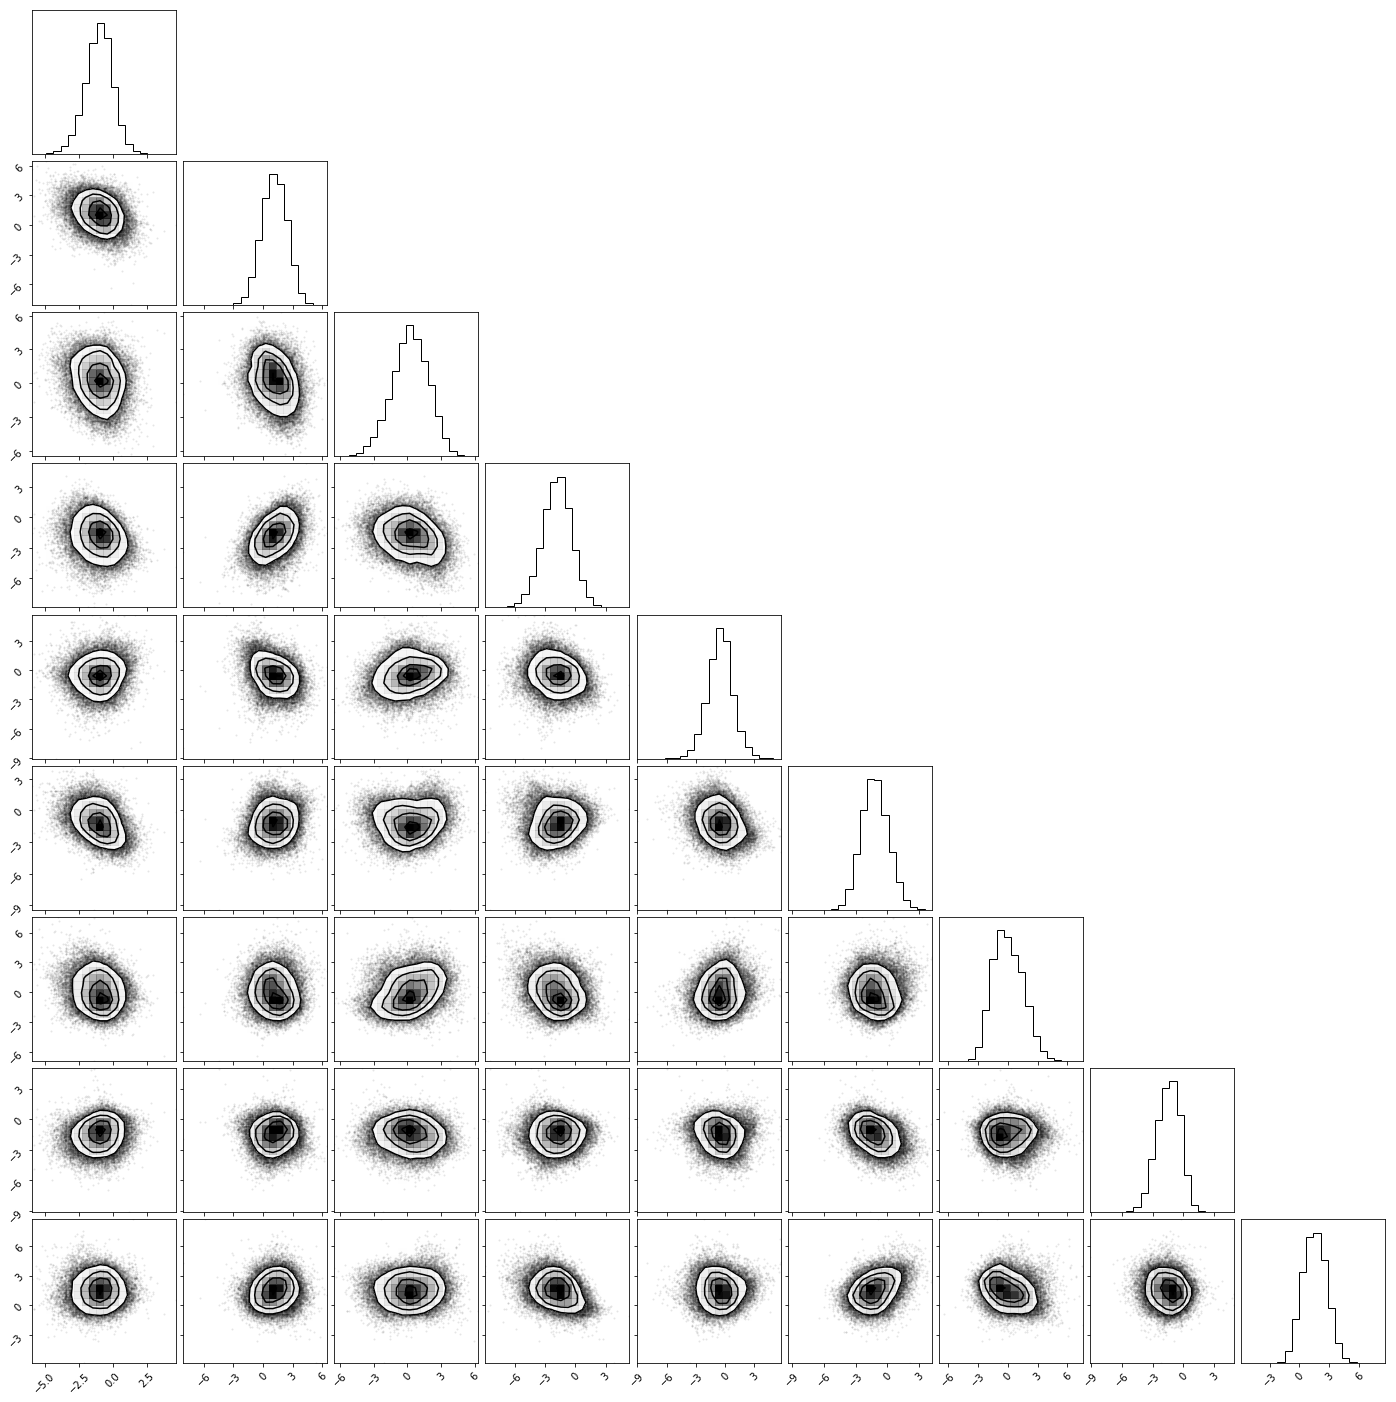

In [0]:
# plot contours of the prior
_ = corner.corner(new_latent[:,5:-1])
plt.savefig(plot_path+'new_prior_contours_%s.png'%data_class, bbox_inches='tight')
# plot comtours of the posterior distribution, fitten by the RealNVP
_ = corner.corner(maf_s[:,0:-1])
plt.savefig(plot_path+'nvp_fitted_posterior_contours_class%d.png'%data_class, bbox_inches='tight')